In [1]:
import sys
import os

import pandas as pd
import numpy as np

sys.path.append("src/datasets/")

# TODO: RIZVAN
describe movielens loading procedure

# Loading IMDB datasets

Datasets with IMDB info are loaded directly from IMDB site: https://datasets.imdbws.com

In [2]:
from src.datasets.download_imdb import load_imdb_datasets

In [3]:
load_imdb_datasets()

[██████████████████████████████████████████████████]
Decompressing... Removing...
[██████████████████████████████████████████████████]
Decompressing... Removing...
[██████████████████████████████████████████████████]
Decompressing... Removing...


# Matching IMDB titles to Movielens titles

Before augmenting the movielens dataset with IMDB titles we need to establish one-to-one correspondence between titles in these datasets. 

As soon as titles are written in a slightly different ways, some manual string processing was applyed. This includes removing the year from the title and moving articles "A", "The" to the beginning of the string.

In [4]:
from src.datasets.extract_movielens_to_imdb_mapping import get_tconst_by_title
from src.datasets.imdb_management import ImdbSearcher

In [5]:
movielens = pd.read_csv("data/movie_lens/movie_lens_1m.csv")
imdb = pd.read_csv("data/imdb/title.basics.tsv", sep='\t')
imdb['originalTitle'] = imdb.originalTitle.astype(str)
imdb['startYear'] = imdb.startYear.astype(str)

searcher = ImdbSearcher(imdb)
title_to_imdb_id = pd.read_csv("data/movielens_to_imdb_mapping.csv")
# title_to_imdb_id = pd.DataFrame({"title": movielens.Title.unique()})
# title_to_imdb_id['tconst'] = title_to_imdb_id.title.apply(get_tconst_by_title, args=[searcher])
# title_to_imdb_id.to_csv("data/movielens_to_imdb_mapping.csv", index=False)
title_to_imdb_id.head(5)

/opt/homebrew/Caskroom/miniforge/base/envs/core_ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,title,tconst
0,One Flew Over the Cuckoo's Nest (1975),tt0073486
1,James and the Giant Peach (1996),tt0116683
2,My Fair Lady (1964),tt0058385
3,Erin Brockovich (2000),tt0195685
4,"Bug's Life, A (1998)",tt0120623


# Dataset augmentation

In [6]:
from src.datasets.augment_movielens import *

## Ratings statistics
First, we add ratings statistics from IMDB dataset. Ratings statistic includes average rating over different users, and number of votes for the film. We've considered the number of votes to be a representative statistics for the film popularity, which in turn can be a good feature for the recommender system.

However, the number of votes comes from a distribution with a very heavy right tail, that makes the feature hard to use for linear models (which our recommender system is). Thus, during the augmentation procedure we apply log scaling for the feature.

This augmentation gives us 2 features for the film

In [7]:
augmented_movielens = augment_with_ratings(movielens)

<AxesSubplot:title={'center':'Logarithm of Num votes distribution'}, ylabel='Frequency'>

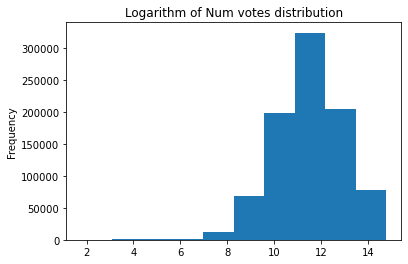

In [8]:
augmented_movielens.logNumVotesMovie.plot.hist(title="Logarithm of Num votes distribution")

## Movie genre
We further augment the dataset with the movie genre. One movie may have several genres, and the genre is a categorial value, so we make a bitmask for each film, which has 1 if the movie belongs to the corresponding genre.

The augmentation gives us 18 features for the film

In [9]:
augmented_movielens = encode_bitmask_genres(augmented_movielens)

<AxesSubplot:title={'center':'Genre feature distribution'}>

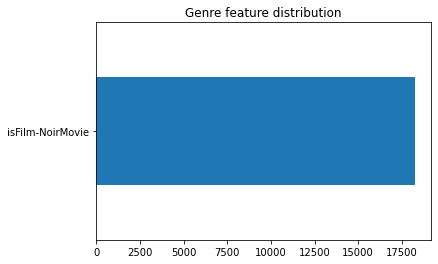

In [10]:
augmented_movielens.loc[:, "isFilm-NoirMovie":].sum(axis=0).plot.barh(title="Genre feature distribution")

## Directors information
### TODO: RIZVAN
make a description for the next cell as I did above and below

In [11]:
augmented_movielens = add_top_directors(augmented_movielens)

## User ages

Further we go to the user features. First, we encode the age. For some reason, the movielens dataset has only a few unique values for the ages, so we assume they were splitted to several bins. This decision is quite useful for our system, as the dependency between the user age and their preferences is not really linear, so we again just make a bitmask, encoding the user age. For this feature, one user may have only one age value, so it basically becomes one-hot encoding (OHE).

We also add the log value of the user age (just in case :O, there is no such a notion of "too much features").

This augmentation gives us 8 features.

In [12]:
augmented_movielens = encode_ohe_age(augmented_movielens)

<AxesSubplot:title={'center':'Age feature distribution'}>

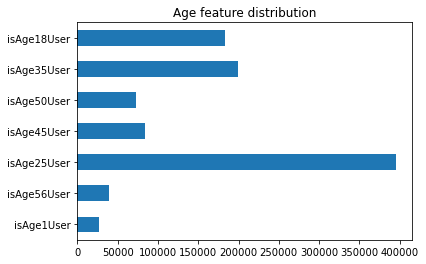

In [13]:
augmented_movielens.iloc[:, -7:].sum(axis=0).plot.barh(title="Age feature distribution")

## Users occupation
Next, we encode the occupation of users. Again, a bitmask which is basically OHE

In [14]:
augmented_movielens = encode_ohe_occupation(augmented_movielens)

<AxesSubplot:title={'center':'Users occupation statistics'}>

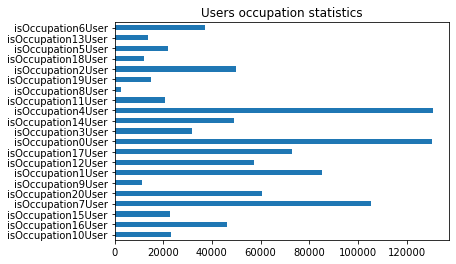

In [15]:
augmented_movielens.loc[:, "isOccupation10User":].sum(axis=0).plot.barh(title="Users occupation statistics")

## Users gender
Finally, the gender. We were brave enough to binarize this value.

In [16]:
augmented_movielens = process_gender(augmented_movielens)

In [17]:
print(f"The {round(100*augmented_movielens.GenderUser.mean(), 1)} of the users self-identify as men")

The 75.4 of the users self-identify as men
